<a href="https://colab.research.google.com/github/gfr10598/pullometer/blob/main/Read_Bell_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from dateutil import parser
import typing
import base64
import numpy as np
import pandas as pd

class LSMRecord:
    def __init__(self, record: bytes) -> None:
        self.tag = record[0] >> 3
        self.cnt = (record[0] >> 1) & 0x3
        self.data = (
            int.from_bytes(record[1:3], byteorder="little", signed=True),
            int.from_bytes(record[3:5], byteorder="little", signed=True),
            int.from_bytes(record[5:7], byteorder="little", signed=True),
        )
        # if self.tag == 3:
        #     print(f"Temperature tag {self.data[0]/256 + 25:6.2f} °C")


class LSM_Line:
    def __init__(self, line: str) -> None:
        self.line = line
        self.time, self.base64 = line.split()
        self.raw = base64.b64decode(self.base64)

    def __iter__(self):
        for i in range(len(self.raw) // 7):
            yield LSMRecord(self.raw[i * 7 : i * 7 + 7])

    def get_time(self):
        return parser.parse(self.time)


class LSM_Reader:
    def __init__(self, f: typing.BinaryIO) -> None:
        self.f = f

    def __iter__(self):
        for line in self.f:
            yield LSM_Line(line)

    def to_dataframe(self, offset: int = 0):
        """Currently this returns omega in rad/sec, and acceleration in g's."""
        xl = []
        gyr = []
        temps = []
        times = []
        counts = []
        for line in self:
            for record in line:
                if record.tag == 1:
                        gyr.append(record.data)
                elif record.tag == 2:
                        xl.append(record.data)
                        while len(temps) > 0 and len(temps) < len(xl):
                            temps.append(temps[-1])
                elif record.tag == 3:
                        while len(temps) < len(xl):
                            temps.append(record.data[0] / 256 + 25)
            times.append(line.get_time().timestamp())
            counts.append(len(xl))
        if offset > 0:
            xl = xl[:-offset]
            gyr = gyr[offset:]
            temps = temps[offset:]
        time_fit = np.polyfit(np.array(counts), np.array(times) - times[0], 1)
        print(f"Time base fit: {time_fit}  {1/time_fit[0]:8.2f} Hz")
        df = pd.DataFrame(xl, columns=["xl_x", "xl_y", "xl_z"])
        df = df * 16 / 32768  # Scale to g.
        # Scale to rad/sec.
        df[["gyr_x", "gyr_y", "gyr_z"]] = pd.DataFrame(gyr) * 0.035 * np.pi / 180
        df["time"] = time_fit[0] * np.arange(len(df))
        df["tempC"] = temps

        if len(temps) > 10:
            rate = len(temps) / (times[-1] - times[0])
            for i in range(10):
                index = (len(temps) // 10) * i
                print(f"Temperature {index/rate:6.2f} {temps[index]:6.2f} °C")
        return df, time_fit[0]



In [36]:
# prompt: load a gz file from github, gunzip, and decode basae64

import requests
from zipfile import ZipFile
import base64
import gzip

# Fetch the gz file from GitHub
url = 'https://github.com/gfr10598/pullometer/raw/main/data/groton_unmuffled.txt.gz'
response = requests.get(url)

# Save the gz file
with open('downloaded.gz', 'wb') as f:
    f.write(response.content)

# Get the file stats
file_stats = response.headers.get('Content-Length')
print(file_stats)

with gzip.open('downloaded.gz', 'rb') as gz_file:
  rdr = LSM_Reader(gz_file)
  df, time_fit = rdr.to_dataframe()
  print(len(df))

ODR = 1/time_fit
print("ODR =", ODR)



2437491
Time base fit: [ 0.00053592 -0.0047201 ]   1865.95 Hz
Temperature   0.00  20.46 °C
Temperature  10.75  20.46 °C
Temperature  21.51  20.46 °C
Temperature  32.26  20.46 °C
Temperature  43.01  20.46 °C
Temperature  53.77  20.46 °C
Temperature  64.52  20.46 °C
Temperature  75.28  20.46 °C
Temperature  86.03  20.46 °C
Temperature  96.78  20.46 °C
200666
ODR = 1865.9454402412618


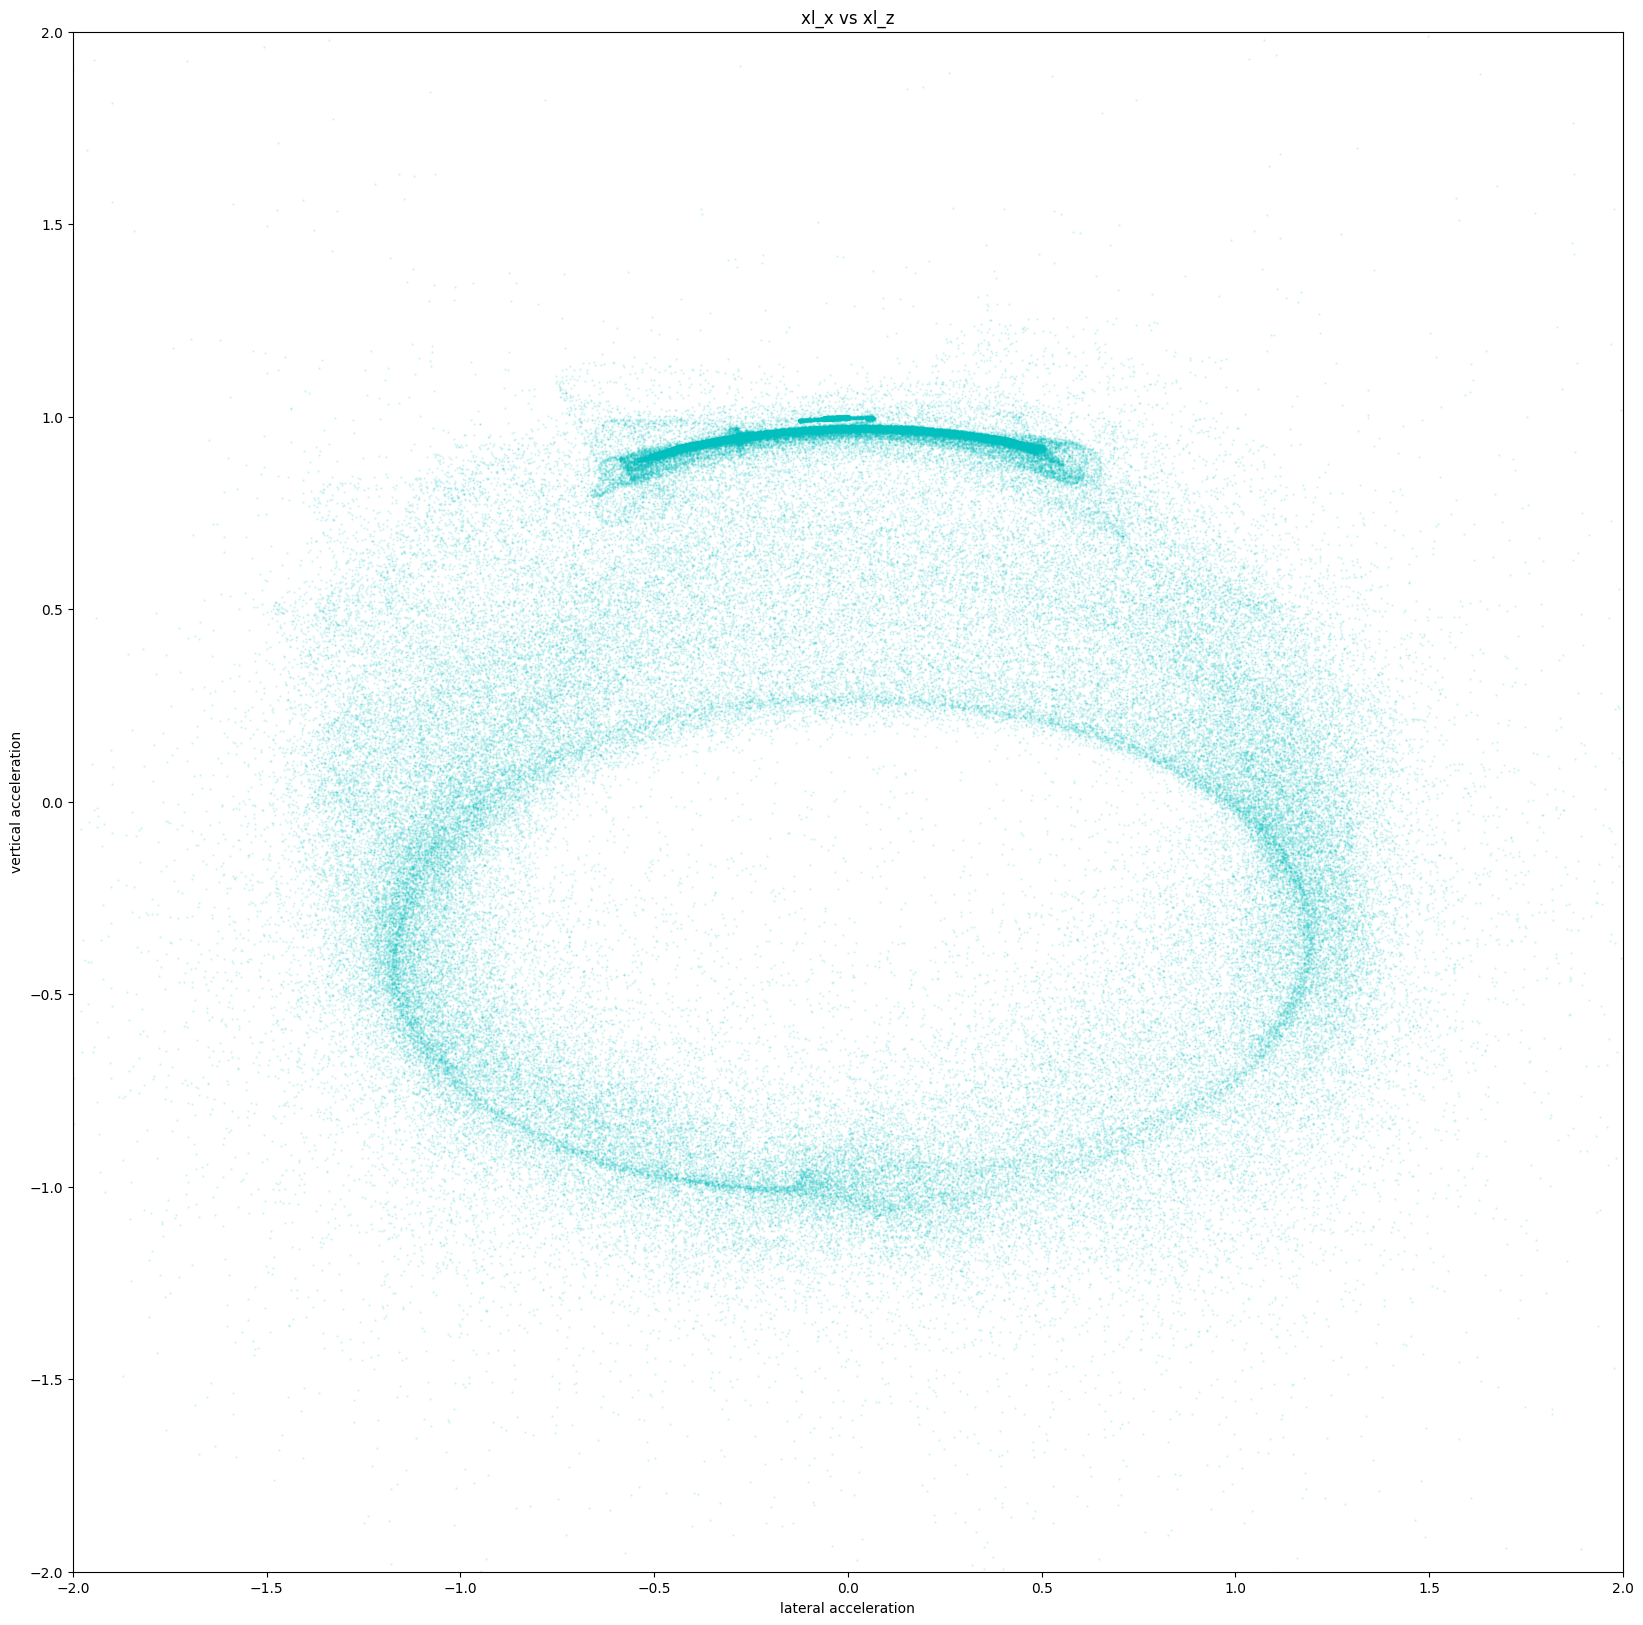

In [35]:
import matplotlib.pyplot as plt
from google.colab import output

output.enable_custom_widget_manager()

plt.figure(figsize=(20,20))
plt.title("xl_x vs xl_z")
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.plot(df["xl_x"], df["xl_z"], "c.", markersize="1", alpha=0.2)
plt.xlabel("lateral acceleration")
plt.ylabel("vertical acceleration")
plt.show()

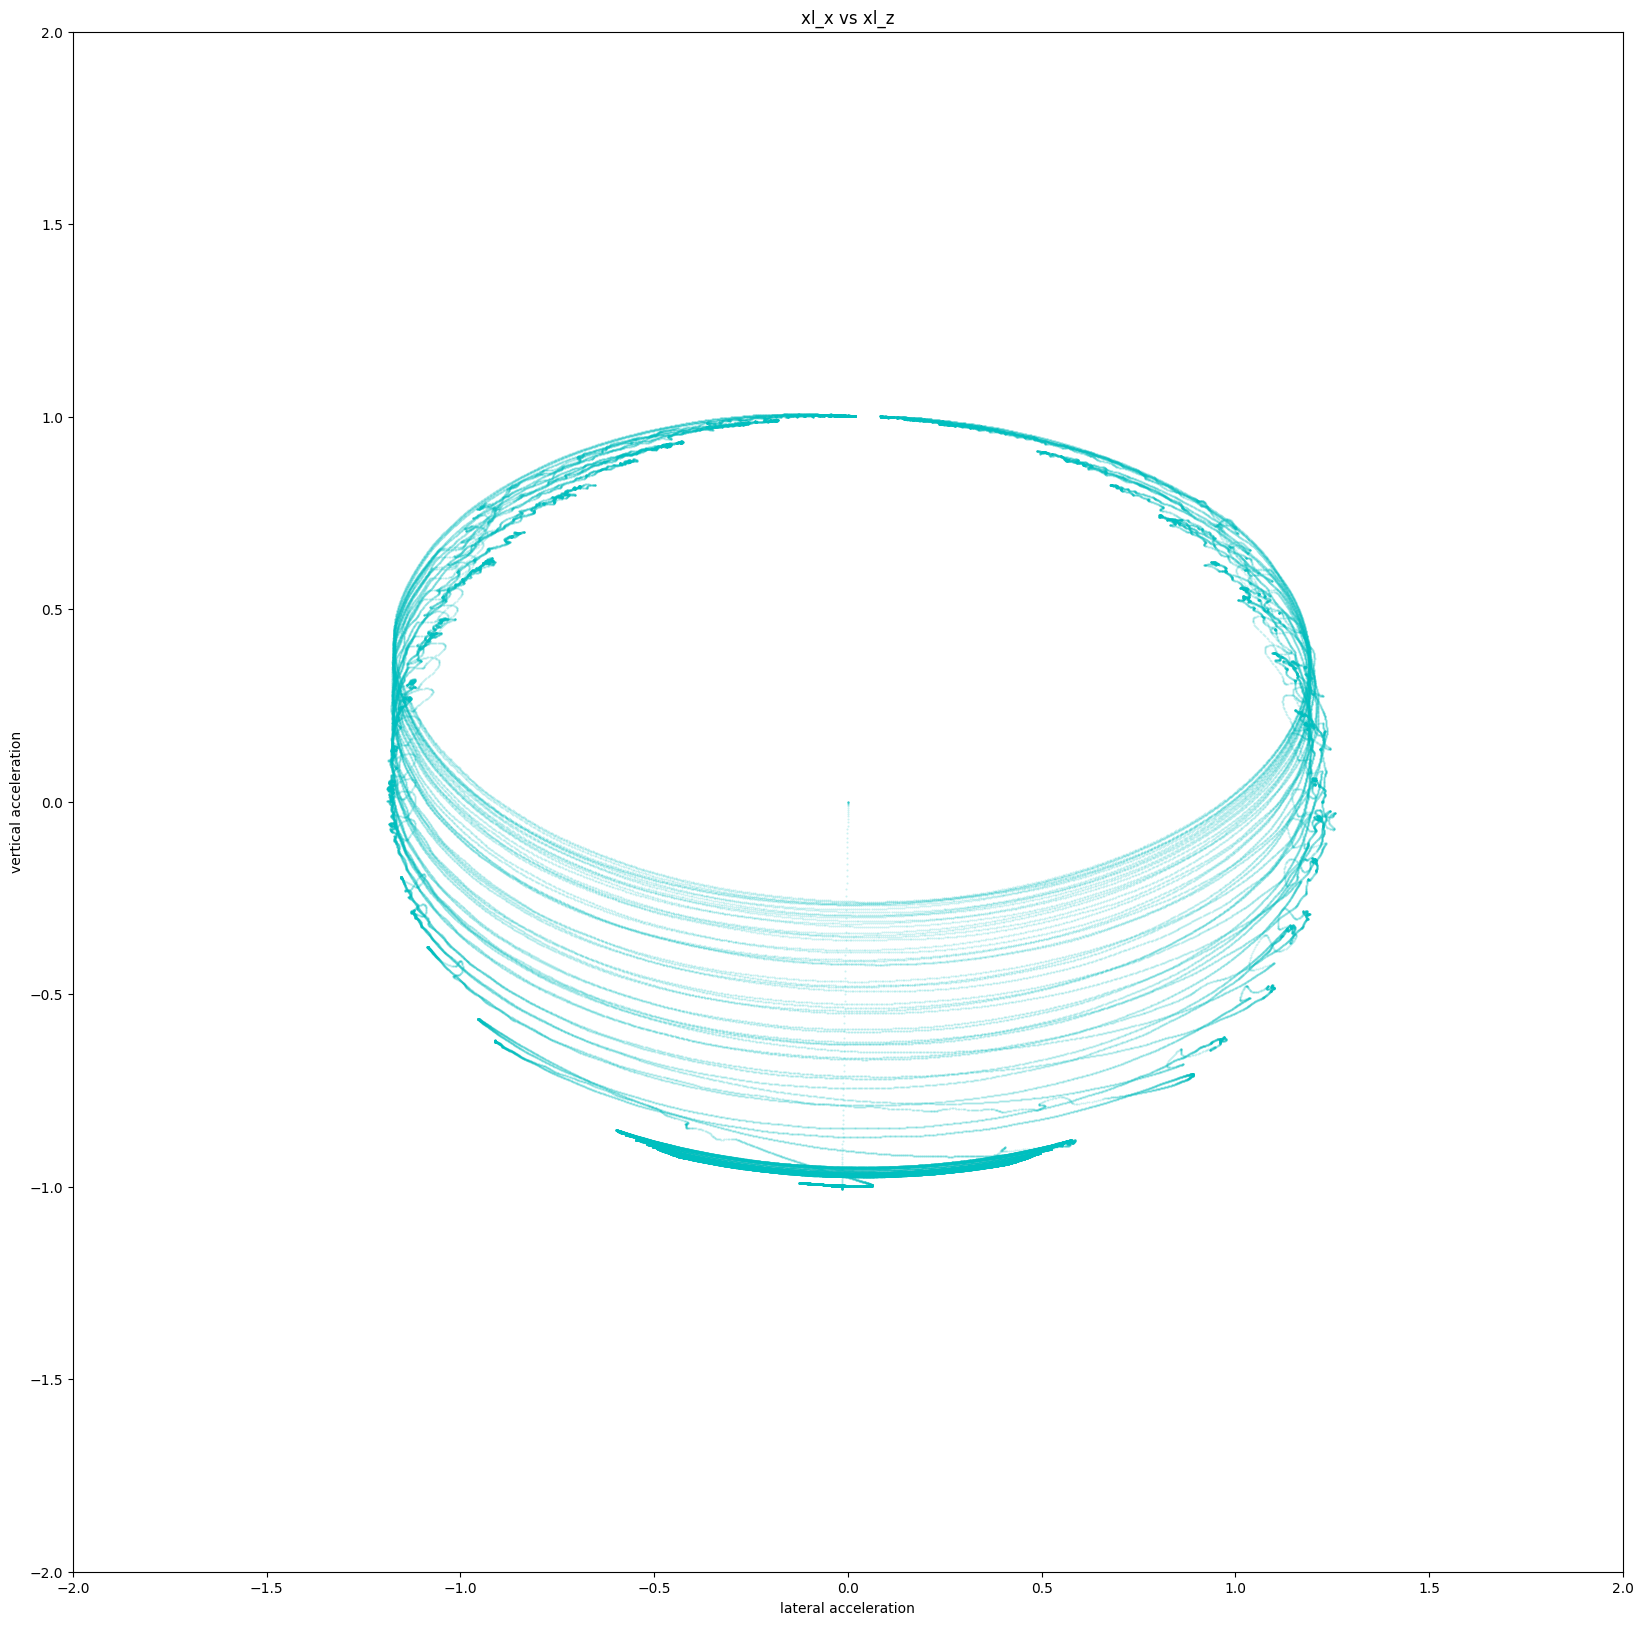

In [40]:
import matplotlib.pyplot as plt
from scipy import signal
from google.colab import output
# This doesn't seem to do anything.  8-(
output.enable_custom_widget_manager()

# Low pass filter the data before plotting
sos = signal.bessel(4, 20, fs=ODR, output="sos")
xlx = signal.sosfilt(sos, df["xl_x"])
xlz = signal.sosfilt(sos, df["xl_z"])

plt.figure(figsize=(20,20))
plt.title("xl_x vs xl_z")
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.plot(xlx, -xlz, "c.", markersize="1", alpha=0.2)
plt.xlabel("lateral acceleration")
plt.ylabel("vertical acceleration")
plt.show()